## Heritability calculations

Calculate heritability for each metabolite as in [Breunig JS, Hackett SR, Rabinowitz JD, Kruglyak L (2014) Genetic Basis of Metabolome Variation in Yeast. PLoS Genet 10(3): e1004142](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004142)

"For each metabolite, segregants with two quantifiable biological replicates were isolated and the variance within replicates was compared to the total across all samples. This is effectively subtracting the environmental variance from the total phenotypic variance to yield the genetic variance. The ratio of genetic variance to phenotypic variance is the broad sense heritability (equation 1)"

$$\hat\sigma^2_s=\frac{\sum_{r=1}^2 (X_{sr}-\bar X_s)^2}{2} . \frac{2}{2-1} $$

$$H^2=1-\frac{\sum_s^S 2 \hat\sigma_s^2}{\sum_s^S \sum_{r=1}^2 (X_{sr}-\bar X)^2} $$

In [5]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(parallel);
options(mc.cores = 24);
library(stringr);
library(RColorBrewer);

In [117]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)
#head(endometabolite)

### Calculate variance across all strains

Denominator in $H^{2}$ equation

In [142]:
all_var = endometabolite %>% filter(time_format == "relative") %>% 
    group_by(metabolite, time) %>% do({
        thismetabolite = .$metabolite[1]
        thistime = .$time[1]
        big_mean = mean(.$value.log2, na.rm = T)
        ssd = sum((.$value.log2 - big_mean)^2, na.rm = T)
        df = data.frame(metabolite = thismetabolite, time = thistime, mean = big_mean, ssd = ssd)
        return(df)
})

### Calculate variance of each strain using replicates

$\hat\sigma^2_s$ above

In [143]:
# use relative time_format
strain_var = endometabolite %>% filter(time_format == "relative") %>% 
    group_by(metabolite, time, strain) %>% do({
        thismetabolite = .$metabolite[1]
        thisstrain = .$strain[1]
        thistime = .$time[1]
        small_mean = mean(.$value.log2)
        var = (sum((.$value.log2 - small_mean)^2)/2) * 2
        df = data.frame(metabolite = thismetabolite, strain = thisstrain, 
                        time = thistime, var = var)
        return(df)
})
strain_var$time = as.factor(strain_var$time)

Warning message:
In rbind_all(out[[1]]): Unequal factor levels: coercing to character

### Calculate $H^{2}$

In [144]:
H2 = strain_var %>% group_by(metabolite, time) %>% do({
    thismetabolite = levels(.$metabolite)[.$metabolite[1]]
    thistime = levels(.$time)[.$time[1]]
    denominator = filter(all_var, metabolite == thismetabolite, time == thistime)
    denominator = denominator$ssd
    H2 = sum(2*.$var,na.rm=T)/denominator
    return(data.frame(metabolite = thismetabolite, time = thistime, H2 = 1-H2))
})

Warning message:
In rbind_all(out[[1]]): Unequal factor levels: coercing to characterWarning message:
In rbind_all(out[[1]]): Unequal factor levels: coercing to character

In [145]:
#H2

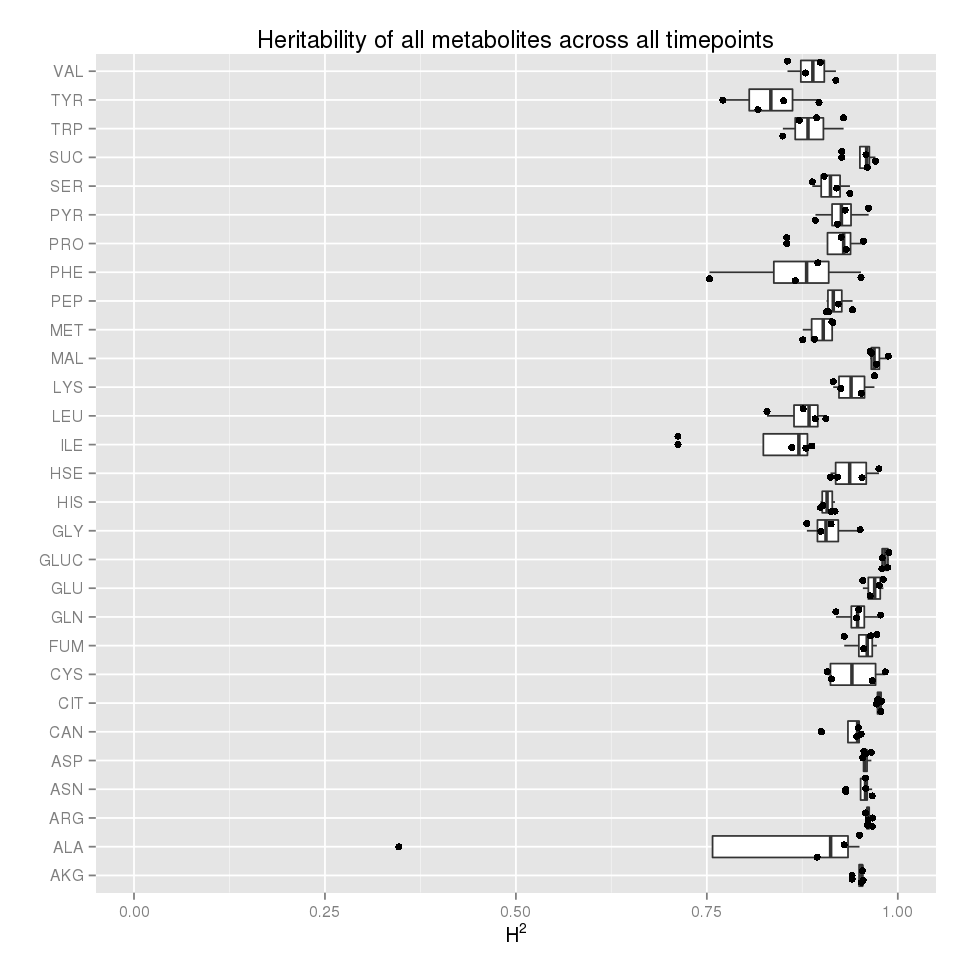

In [146]:
options(repr.plot.height = 8)
p <- ggplot(H2, aes(metabolite, H2))
p + geom_boxplot() + geom_jitter(width = 0) + coord_flip() +
    ylim(c(0,1)) + labs(title = "Heritability of all metabolites across all timepoints", 
                        y = expression(paste(H^{2})), x = "")